In [1]:
import os
import time

import functions
from mappings import *

import numpy as np
import pandas as pd

from itertools import chain
from functools import reduce
from datetime import datetime
from collections import defaultdict

from pyspark.sql import Window, SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LinearSVC, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from elasticsearch import Elasticsearch

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Initialize Spark

We will create our Spark program using **SparkSession** ...

In [2]:
appName = "my-tfm"

ss = SparkSession.builder.appName(appName).config("spark.some.config.option", "4g").getOrCreate()
print(ss)
sc = ss.sparkContext
print(sc)

<SparkContext master=yarn appName=my-tfm>


# Loading

We will load the data previously downloaded from its source:

* **Historical data:** http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

* **Prediction data:** https://www.kaggle.com/kumargh/pimaindiansdiabetescsv

* **Analysis (time-series):** http://archive.ics.uci.edu/ml/datasets/Diabetes

In [3]:
# Load first dataset (historical data)
hist_data = functions.load_data(ss, "diabetic_data.csv")

07-09-2020 21:21:25 - Loading diabetic_data.csv file....
Loaded 101766 rows and 50 columns
+------------+-----------+---------+------+------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|     race|gender|   age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_out

In [4]:
# Load second dataset (prediction data)
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',\
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Class']
pred_data = functions.load_data(ss, "pima-indians-diabetes.csv", hdr=False, col_names=col_names)

07-09-2020 21:26:36 - Loading pima-indians-diabetes.csv file....
Loaded 768 rows and 9 columns
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Class|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|    1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+
only showing top 1 row

07-09-2020 21:26:40 - Load completed. This operation has taken 3.91 s


In [5]:
# Load third dataset (analysis data)
an_data = functions.load_ts(sc, 70, 'data') # the function load_ts already imputes missing values when loading the file

07-09-2020 21:26:40 - Loading data-01 file....
Loaded 943 rows and 5 columns
07-09-2020 21:26:51 - Loading data-02 file....
Loaded 761 rows and 5 columns
07-09-2020 21:26:53 - Loading data-03 file....
Loaded 300 rows and 5 columns
07-09-2020 21:26:54 - Loading data-04 file....
Loaded 300 rows and 5 columns
07-09-2020 21:26:55 - Loading data-05 file....
Loaded 300 rows and 5 columns
07-09-2020 21:26:57 - Loading data-06 file....
Loaded 149 rows and 5 columns
07-09-2020 21:26:58 - Loading data-07 file....
Loaded 242 rows and 5 columns
07-09-2020 21:26:59 - Loading data-08 file....
Loaded 177 rows and 5 columns
07-09-2020 21:27:01 - Loading data-09 file....
Loaded 206 rows and 5 columns
07-09-2020 21:27:03 - Loading data-10 file....
Loaded 247 rows and 5 columns
07-09-2020 21:27:04 - Loading data-11 file....
Loaded 236 rows and 5 columns
07-09-2020 21:27:05 - Loading data-12 file....
Loaded 300 rows and 5 columns
07-09-2020 21:27:06 - Loading data-13 file....
Loaded 300 rows and 5 columns

# Preprocessing

### Historical data

Remove the rows and columns with more than 30% of missing values and replace the rest with the mode of the column.

In [6]:
hist_data = functions.impute_na(hist_data)


07-09-2020 21:28:05 - Working with missing values...
Removing rows with more than 30% of missing data...
0 rows removed

Showing columns with missing values: 
                   count  density
race                2273     0.02
weight             98569     0.97
payer_code         40256     0.40
medical_specialty  49949     0.49
diag_1                21     0.00
diag_2               358     0.00
diag_3              1423     0.01

Removing rows with more than 30% of missing data (weight, payer_code, medical_specialty) ...

07-09-2020 21:30:01 - Columns removed. 
New shape: (101766 rows x 47 columns)

07-09-2020 21:30:03 - Replacing missing values...
Replacing NAs values of attribute race by value Caucasian
Replacing NAs values of attribute diag_1 by value 428
Replacing NAs values of attribute diag_2 by value 276
Replacing NAs values of attribute diag_3 by value 250

07-09-2020 21:30:48 - Missing values removed.  This operation has taken 163.48 s


Cast IDs with numbers to String.

In [7]:
hist_data = hist_data.withColumn("encounter_id",hist_data["encounter_id"].cast(StringType())) \
                    .withColumn("discharge_disposition_id",hist_data["discharge_disposition_id"].cast(StringType())) \
                    .withColumn("admission_source_id",hist_data["admission_source_id"].cast(StringType())) \
                    .withColumn("admission_type_id",hist_data["admission_type_id"].cast(StringType())) \
                    .withColumn("patient_nbr",hist_data["patient_nbr"].cast(StringType()))

hist_data.printSchema()

root
 |-- encounter_id: string (nullable = true)
 |-- patient_nbr: string (nullable = true)
 |-- race: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = false)
 |-- diag_2: string (nullable = false)
 |-- diag_3: string (nullable = false)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- r

Explore the data

Number of categorical variables: 39	 Percentage: 82.98%
Number of numerical variables: 8	 Percentage: 17.02%


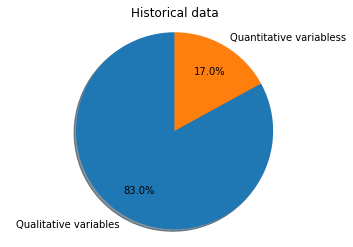

In [8]:
data_types = defaultdict(list)
for entry in hist_data.schema.fields:
     data_types[str(entry.dataType)].append(entry.name)
        
categorical_variables = len(data_types["StringType"])
categorical_var_size =100*(categorical_variables/len(hist_data.columns))
print("Number of categorical variables: {}\t Percentage: {:.2f}%". format(categorical_variables, categorical_var_size))

numerical_variables = len(data_types["IntegerType"])
numerical_var_size = 100*(numerical_variables/len(hist_data.columns))
print("Number of numerical variables: {}\t Percentage: {:.2f}%". format(numerical_variables, numerical_var_size))

fig1, ax1 = plt.subplots()
sizes = [categorical_var_size, numerical_var_size]
explode=[0,0]
labels=['Qualitative variables', 'Quantitative variabless']
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, pctdistance=0.7, labeldistance=1.1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Historical data")

plt.show()

Text(0, 0.5, 'Relative frequency')

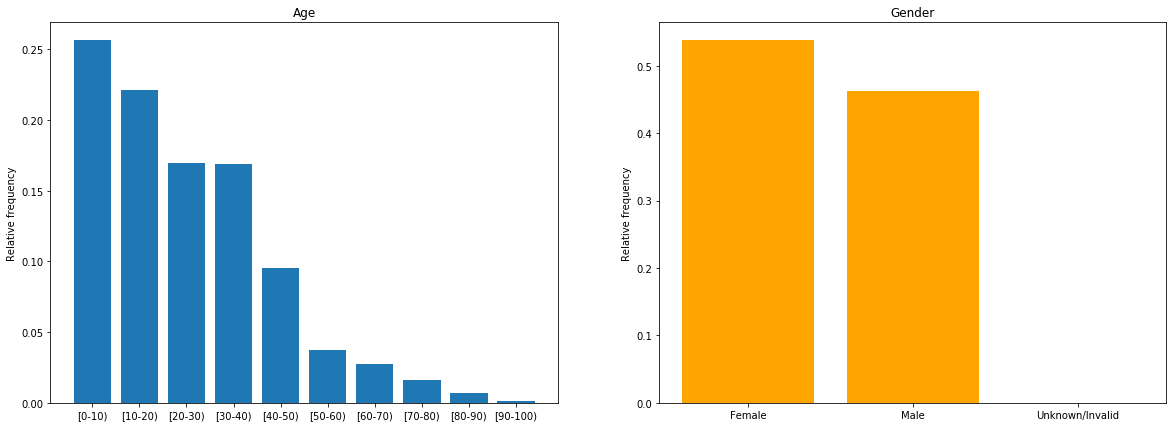

In [9]:
fig1, ax1 = plt.subplots(1,2,figsize=(20,7))

aux = hist_data.select("Age").toPandas()
ax1[0].bar(aux["Age"].unique(), aux["Age"].value_counts()/hist_data.count())
ax1[0].set_title("Age")
ax1[0].set_ylabel("Relative frequency")

aux = hist_data.select("gender").toPandas()
ax1[1].bar(aux["gender"].unique(), aux["gender"].value_counts()/hist_data.count(), color="orange")
ax1[1].set_title("Gender")
ax1[1].set_ylabel("Relative frequency")

Text(0, 0.5, 'Relative frequency')

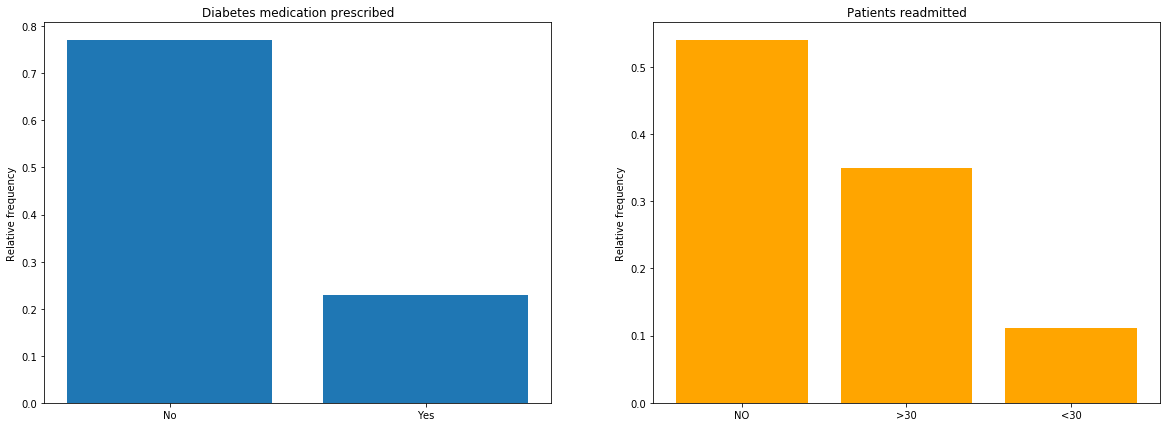

In [10]:
fig1, ax1 = plt.subplots(1,2,figsize=(20,7))

aux = hist_data.select("diabetesMed").toPandas()
ax1[0].bar(aux["diabetesMed"].unique(), aux["diabetesMed"].value_counts()/hist_data.count())
ax1[0].set_title("Diabetes medication prescribed")
ax1[0].set_ylabel("Relative frequency")

aux = hist_data.select("readmitted").toPandas()
ax1[1].bar(aux["readmitted"].unique(), aux["readmitted"].value_counts()/hist_data.count(), color="orange")
ax1[1].set_title("Patients readmitted")
ax1[1].set_ylabel("Relative frequency")

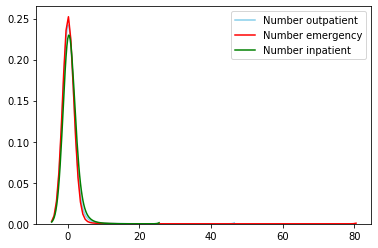

In [11]:
aux1 = hist_data.select("number_outpatient").toPandas()
sns.kdeplot(aux1["number_outpatient"], bw=1.5 , color="skyblue", label="Number outpatient")
            
aux2 = hist_data.select("number_emergency").toPandas()
sns.kdeplot( aux2["number_emergency"], bw=1.5 , color="red", label="Number emergency")

aux2 = hist_data.select("number_inpatient").toPandas()
sns.kdeplot( aux2["number_inpatient"], bw=1.5 ,color="green", label="Number inpatient")

Filter the columns to be used in the machine learning model in a new variable. 

In [12]:
columns_to_drop = ['encounter_id', 'race', 'age', 'payer_code', 'medical_specialty']
hist_data_aux = hist_data.drop(*columns_to_drop)

hist_data_aux = hist_data_aux.select(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                                 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                                  'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                                 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                                 'metformin-pioglitazone', 'readmitted'])

In [13]:
hist_data_aux.printSchema()

root
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nullable = true)
 |-- glipizide: string (nullable = true)
 |-- glyburide: string (nullable = true)
 |-- tolbutamide: string (nullable = true)
 |-- pioglitazone: string (nullable = true)
 |-- rosiglitazone: string (nullable = true)
 |-- acarbose: string (nullable = true)
 |-- miglitol: string (nullable = true)
 |-- troglitazone: string (nullable = true)
 |-- tolazamide: string (nullable = true)
 |-- examide: string (nullable = true)
 |-- citoglipton: string (nullable = true)
 |-- insulin: string (nullable = true)
 |-- glyburide-metformin: string (nullable = true)
 |-- glipizide-metformin: string (nullable = true)
 |-- glimepiride-pioglitazone: string (nullable = true)
 |-- metformin-rosiglitazone: string (nullable = true)
 |-- metformin-piogl

Map the necessary variables

In [14]:
## New dataset: transform to binary class
mapping_expr = create_map([lit(x) for x in chain(*readmitted_mapping.items())])
hist_data_aux = hist_data_aux.withColumn("readmitted", mapping_expr.getItem(col("readmitted"))) 

## Final dataset: admission type
mapping_expr = create_map([lit(x) for x in chain(*admission_type_id_mapping.items())])
hist_data = hist_data.withColumn("admission_type_id", mapping_expr.getItem(col("admission_type_id")))

## Final dataset: 
mapping_expr = create_map([lit(x) for x in chain(*discharge_disposition_id_mapping.items())])
hist_data = hist_data.withColumn("discharge_disposition_id", mapping_expr.getItem(col("discharge_disposition_id")))

## Final dataset: 
mapping_expr = create_map([lit(x) for x in chain(*admission_source_id_mapping.items())])
hist_data = hist_data.withColumn("admission_source_id", mapping_expr.getItem(col("admission_source_id")))

## Final dataset: 
mapping_expr = create_map([lit(x) for x in chain(*meds_mapping.items())])
hist_data = hist_data.withColumn("metformin", mapping_expr.getItem(col("metformin"))) \
                    .withColumn("repaglinide", mapping_expr.getItem(col("repaglinide"))) \
                    .withColumn("nateglinide", mapping_expr.getItem(col("nateglinide"))) \
                    .withColumn("chlorpropamide", mapping_expr.getItem(col("chlorpropamide"))) \
                    .withColumn("glimepiride", mapping_expr.getItem(col("glimepiride"))) \
                    .withColumn("acetohexamide", mapping_expr.getItem(col("acetohexamide"))) \
                    .withColumn("glipizide", mapping_expr.getItem(col("glipizide"))) \
                    .withColumn("glyburide", mapping_expr.getItem(col("glyburide"))) \
                    .withColumn("tolbutamide", mapping_expr.getItem(col("tolbutamide"))) \
                    .withColumn("pioglitazone", mapping_expr.getItem(col("pioglitazone"))) \
                    .withColumn("rosiglitazone", mapping_expr.getItem(col("rosiglitazone"))) \
                    .withColumn("acarbose", mapping_expr.getItem(col("acarbose"))) \
                    .withColumn("miglitol", mapping_expr.getItem(col("miglitol"))) \
                    .withColumn("troglitazone", mapping_expr.getItem(col("troglitazone"))) \
                    .withColumn("tolazamide", mapping_expr.getItem(col("tolazamide"))) \
                    .withColumn("examide", mapping_expr.getItem(col("examide"))) \
                    .withColumn("citoglipton", mapping_expr.getItem(col("citoglipton"))) \
                    .withColumn("insulin", mapping_expr.getItem(col("insulin"))) \
                    .withColumn("glyburide-metformin", mapping_expr.getItem(col("glyburide-metformin"))) \
                    .withColumn("glipizide-metformin", mapping_expr.getItem(col("glipizide-metformin"))) \
                    .withColumn("glimepiride-pioglitazone", mapping_expr.getItem(col("glimepiride-pioglitazone"))) \
                    .withColumn("metformin-rosiglitazone", mapping_expr.getItem(col("metformin-rosiglitazone"))) \
                    .withColumn("metformin-pioglitazone", mapping_expr.getItem(col("metformin-pioglitazone")))

## Final dataset: 
mapping_expr = create_map([lit(x) for x in chain(*change_mapping.items())])
hist_data = hist_data.withColumn("change", mapping_expr.getItem(col("change")))

## Final dataset: 
mapping_expr = create_map([lit(x) for x in chain(*diabetesMed_mapping.items())])
hist_data = hist_data.withColumn("diabetesMed", mapping_expr.getItem(col("diabetesMed")))

## Final dataset: 
mapping_expr = create_map([lit(x) for x in chain(*readmitted_mapping.items())])
hist_data = hist_data.withColumn("readmitted", mapping_expr.getItem(col("readmitted"))) \
                        .withColumnRenamed("readmitted", "readmitted_trunc")

## Final dataset: diagnostics 
hist_data = hist_data.withColumn("diag_1", translate(col("diag_1"), ".", "")) \
                     .withColumn("diag_2", translate(col("diag_2"), ".", "")) \
                     .withColumn("diag_3", translate(col("diag_3"), ".", ""))

df = ss.read.load("tfm-marta/data/CMS30_DESC_LONG_DX.csv", format="csv", sep=";", inferSchema=True)
diag_mapping = df.toPandas().set_index('_c0').to_dict()['_c1']
diag_mapping

mapping_expr = create_map([lit(x) for x in chain(*diag_mapping.items())])
hist_data = hist_data.withColumn("diag_1", mapping_expr.getItem(col("diag_1"))) \
                     .withColumn("diag_2", mapping_expr.getItem(col("diag_2"))) \
                     .withColumn("diag_3", mapping_expr.getItem(col("diag_3")))

## Final dataset: add new column: date
hist_data = hist_data.withColumn('date', lit(datetime.now().strftime("%d-%m-%Y")))
hist_data = hist_data.withColumn('date', to_timestamp(unix_timestamp(hist_data.date, 'MM-dd-yyyy')))

Transform categorical variables with more than 1 category using One-hot-encoding

In [15]:
## count number of categories of each categorical variable
data_types = defaultdict(list)
for entry in hist_data_aux.schema.fields:
     data_types[str(entry.dataType)].append(entry.name)

counts_summary = hist_data_aux.agg(*[countDistinct(c).alias(c) for c in data_types["StringType"]])
counts_summary = counts_summary.toPandas()

counts = pd.Series(counts_summary.values.ravel())
counts.index = counts_summary.columns

sorted_vars = counts.sort_values(ascending = False) # number of categories of each variable
ignore = list((sorted_vars[sorted_vars <=1]).index) # variables with less than 1 category
# We'll ignore the categorical variables with only 1 category

strings_used = [var for var in data_types["StringType"] if var not in ignore]
stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
hist_data_trunc = ppl.fit(hist_data_aux).transform(hist_data_aux)

Combine all the features into a single vector for each observation

In [16]:
features = data_types["IntegerType"] + [var + "_one_hot" for var in strings_used]
hist_data_trunc = VectorAssembler(inputCols = [x for x in features if x not in 'readmitted'], outputCol= "features")\
                .transform(hist_data_trunc).select(['readmitted', 'features'])

Split data into training, validation and test sets

In [17]:
## Split data into train, validation and test
train_histC_trunc, test_hist_trunc = functions.df_split(hist_data_trunc, 0.7)
train_hist_trunc, val_hist_trunc = functions.df_split(train_histC_trunc, 0.7)

## Split data into X and Y coordinates
train_hist_trunc, val_hist_trunc =  functions.df_split(train_histC_trunc, 0.7)

print("train_hist: {0} x {1}\t val_hist: {2} x {3}\t test_hist: {4} x {5}"\
      .format(train_hist_trunc.count(), len(train_hist_trunc.columns),
              val_hist_trunc.count(), len(val_hist_trunc.columns),
              test_hist_trunc.count(), len(test_hist_trunc.columns)))

train_hist: 49690 x 2	 val_hist: 21370 x 2	 test_hist: 30706 x 2


### Prediction data

Remove the rows and columns with more than 30% of missing values and replace the rest with the mode of the column.

In [18]:
pred_data = functions.impute_na(pred_data)
pred_data.printSchema()


07-09-2020 21:36:06 - Working with missing values...
Removing rows with more than 30% of missing data...
0 rows removed

Showing columns with missing values: 
Empty DataFrame
Columns: [count, density]
Index: []

Removing rows with more than 30% of missing data () ...

07-09-2020 21:36:09 - Columns removed. 
New shape: (768 rows x 9 columns)

07-09-2020 21:36:09 - Replacing missing values...

07-09-2020 21:36:10 - Missing values removed.  This operation has taken 3.77 s
root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Class: integer (nullable = true)



Number of categorical variables: 0	 Percentage: 0.00%
Number of numerical variables: 9	 Percentage: 100.00%


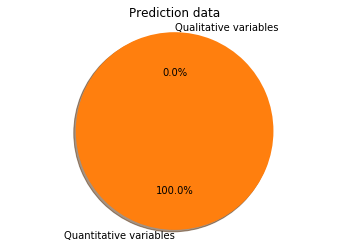

In [19]:
data_types = defaultdict(list)
for entry in pred_data.schema.fields:
     data_types[str(entry.dataType)].append(entry.name)
        
categorical_variables = len(data_types["StringType"])
categorical_var_size =100*(categorical_variables/len(pred_data.columns))
print("Number of categorical variables: {}\t Percentage: {:.2f}%". format(categorical_variables, categorical_var_size))

numerical_variables = len(data_types["IntegerType"])+len(data_types["DoubleType"])
numerical_var_size = 100*(numerical_variables/len(pred_data.columns))
print("Number of numerical variables: {}\t Percentage: {:.2f}%". format(numerical_variables, numerical_var_size))

fig1, ax1 = plt.subplots()
sizes = [categorical_var_size, numerical_var_size]
explode=[0,0]
labels=['Qualitative variables', 'Quantitative variables']
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90,  pctdistance=0.6, labeldistance=1.05)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Prediction data")
plt.show()

Text(0, 0.5, 'Relative frequency')

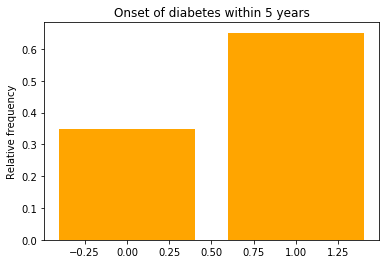

In [20]:
aux = pred_data.select("Class").toPandas()
plt.bar(aux["Class"].unique(), aux["Class"].value_counts()/pred_data.count(), color="orange")
plt.title("Onset of diabetes within 5 years")
plt.ylabel("Relative frequency")


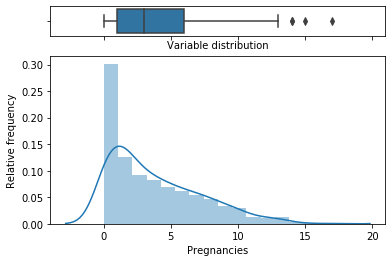

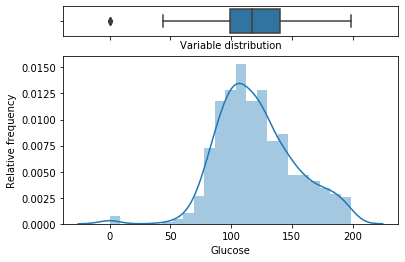

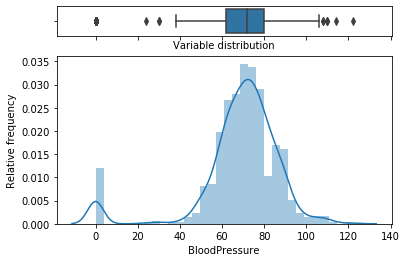

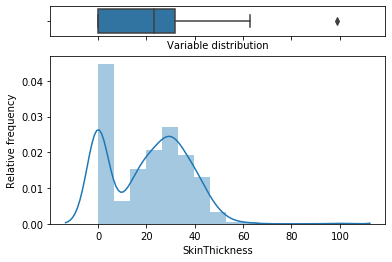

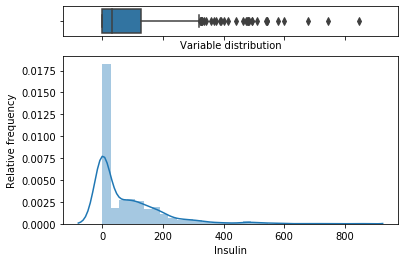

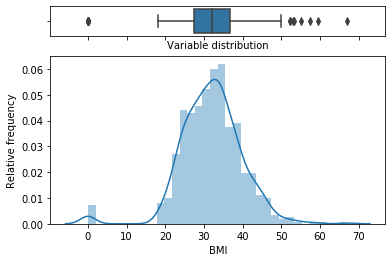

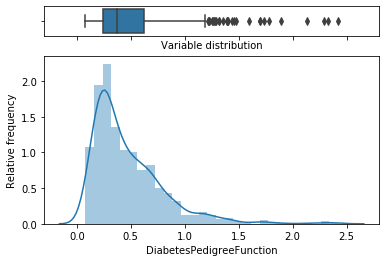

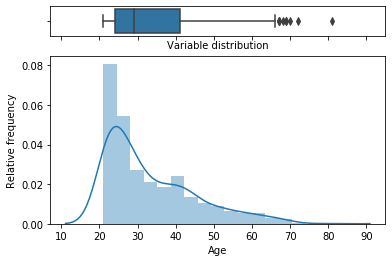

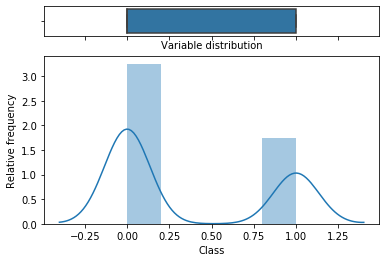

In [21]:
for pred_data_variable in pred_data.columns:
    df = pred_data.select(pred_data_variable).toPandas()
 
    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
    # Add a graph in each part
    sns.boxplot(df[pred_data_variable], ax=ax_box)
    sns.distplot(df[pred_data_variable], ax=ax_hist)
 
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='Variable distribution')
    
    ax_hist.set(ylabel='Relative frequency')

Split the dataset into validation (21%), training (49%) and test (30%)

In [22]:
## Split data into train, validation and test
train_predC, test_pred = functions.df_split(pred_data, 0.7)
train_pred, val_pred = functions.df_split(train_predC, 0.7)

## Split data into X and Y coordinates
Xtrain_pred, ytrain_pred = train_pred.select(train_pred.columns[0:len(train_pred.columns)-1]), train_pred.select('Class')
Xval_pred, yval_pred =  val_pred.select(val_pred.columns[0:len(val_pred.columns)-1]), val_pred.select('Class')
Xtest_pred, ytest_pred = test_pred.select(test_pred.columns[0:len(test_pred.columns)-1]), test_pred.select('Class')

print("Xtrain_pred: {0} x {1}\t ytrain_pred: {2} x {3}".format(Xtrain_pred.count(), len(Xtrain_pred.columns),
                                                              ytrain_pred.count(), len(ytrain_pred.columns)))
print("Xval_pred: {0} x {1}\t yval_pred: {2} x {3}".format(Xval_pred.count(), len(Xval_pred.columns),
                                                              yval_pred.count(), len(yval_pred.columns)))
print("Xtest_pred: {0} x {1}\t ytest_pred: {2} x {3}".format(Xtest_pred.count(), len(Xtest_pred.columns),
                                                              ytest_pred.count(), len(ytest_pred.columns)))

Xtrain_pred: 368 x 8	 ytrain_pred: 368 x 1
Xval_pred: 165 x 8	 yval_pred: 165 x 1
Xtest_pred: 235 x 8	 ytest_pred: 235 x 1


Combine all the features into a single vector for each observation

In [23]:
# Put together all the input attributes.
assembler = VectorAssembler(inputCols=[x for x in train_predC.columns if x not in 'Class'], outputCol='features')

train_predC_trunc = assembler.transform(train_predC).select(['Class', 'features'])
train_pred_trunc = assembler.transform(train_pred).select(['Class', 'features'])
val_pred_trunc = assembler.transform(val_pred).select(['Class', 'features'])
test_pred_trunc = assembler.transform(test_pred).select(['Class', 'features'])

Add columns: date and patient number

In [24]:
pred_data = pred_data.withColumn("new_column",lit("ABC"))
w = Window().partitionBy('new_column').orderBy(lit('A'))
pred_data = pred_data.withColumn("patient_nbr", 50125+row_number().over(w)).drop("new_column")
pred_data = pred_data.withColumn("patient_nbr",pred_data["patient_nbr"].cast(StringType()))
pred_data = pred_data.withColumn('date', lit(datetime.now().strftime("%d-%m-%Y")))
pred_data = pred_data.withColumn('date', to_timestamp(unix_timestamp(pred_data.date, 'MM-dd-yyyy')))

###  Analytical data

In [25]:
an_data.printSchema()

root
 |-- code: string (nullable = true)
 |-- value: string (nullable = true)
 |-- patient_nbr: integer (nullable = false)
 |-- date: timestamp (nullable = true)



Number of categorical variables: 3	 Percentage: 75.00%
Number of numerical variables: 1	 Percentage: 25.00%


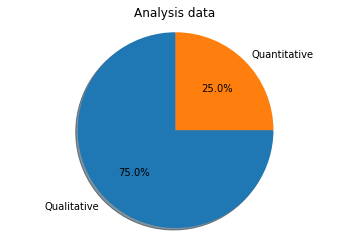

In [26]:
data_types = defaultdict(list)
for entry in an_data.schema.fields:
     data_types[str(entry.dataType)].append(entry.name)
        
categorical_variables = len(data_types["StringType"])+len(data_types["TimestampType"])
categorical_var_size =100*(categorical_variables/len(an_data.columns))
print("Number of categorical variables: {}\t Percentage: {:.2f}%". format(categorical_variables, categorical_var_size))

numerical_variables = len(data_types["IntegerType"])+len(data_types["DoubleType"])
numerical_var_size = 100*(numerical_variables/len(an_data.columns))
print("Number of numerical variables: {}\t Percentage: {:.2f}%". format(numerical_variables, numerical_var_size))

fig1, ax1 = plt.subplots()
sizes = [categorical_var_size, numerical_var_size]
explode=[0,0]
labels=['Qualitative', 'Quantitative']
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Analysis data")
plt.show()

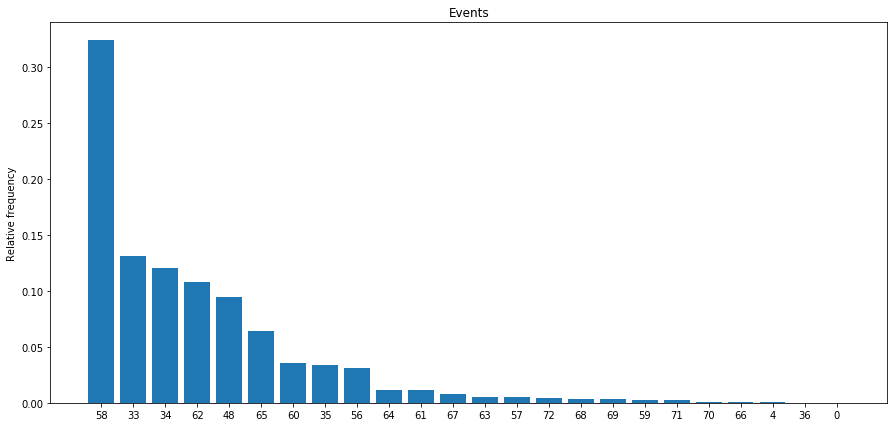

In [27]:
plt.figure(figsize=(15,7))
aux = an_data.select("code").toPandas()
plt.bar(aux["code"].unique(), aux["code"].value_counts()/an_data.count())
plt.title("Events")
plt.ylabel("Relative frequency")
plt.rcParams.update({'font.size': 16})

In [28]:
mapping['58']

'Pre-breakfast blood glucose measurement'

In [29]:
an_data = an_data.withColumn("value",an_data["value"].cast(IntegerType())) 

mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])
an_data = an_data.withColumn("code", mapping_expr.getItem(col("code"))) \
                 .withColumn("patient_nbr",an_data["patient_nbr"].cast(StringType())) \
                 .withColumn('date', an_data.date + expr('INTERVAL 29 years'))
an_data.printSchema()
an_data.show()

root
 |-- code: string (nullable = true)
 |-- value: integer (nullable = true)
 |-- patient_nbr: string (nullable = false)
 |-- date: timestamp (nullable = true)

+--------------------+-----+-----------+-------------------+
|                code|value|patient_nbr|               date|
+--------------------+-----+-----------+-------------------+
|Pre-breakfast blo...|  100|      70126|2020-04-21 09:09:00|
|Regular insulin dose|    9|      70126|2020-04-21 09:09:00|
|    NPH insulin dose|   13|      70126|2020-04-21 09:09:00|
|Pre-supper blood ...|  119|      70126|2020-04-21 17:08:00|
|Regular insulin dose|    7|      70126|2020-04-21 17:08:00|
|Unspecified blood...|  123|      70126|2020-04-21 22:51:00|
|Pre-breakfast blo...|  216|      70126|2020-04-22 07:35:00|
|Regular insulin dose|   10|      70126|2020-04-22 07:35:00|
|    NPH insulin dose|   13|      70126|2020-04-22 07:35:00|
|Regular insulin dose|    2|      70126|2020-04-22 13:40:00|
|Pre-supper blood ...|  211|      70126|2020

# Analyzing and predicting the data

### Historical data

Explore the data

Number of categorical variables: 23	 Percentage: 47.92%
Number of numerical variables: 1	 Percentage: 2.08%


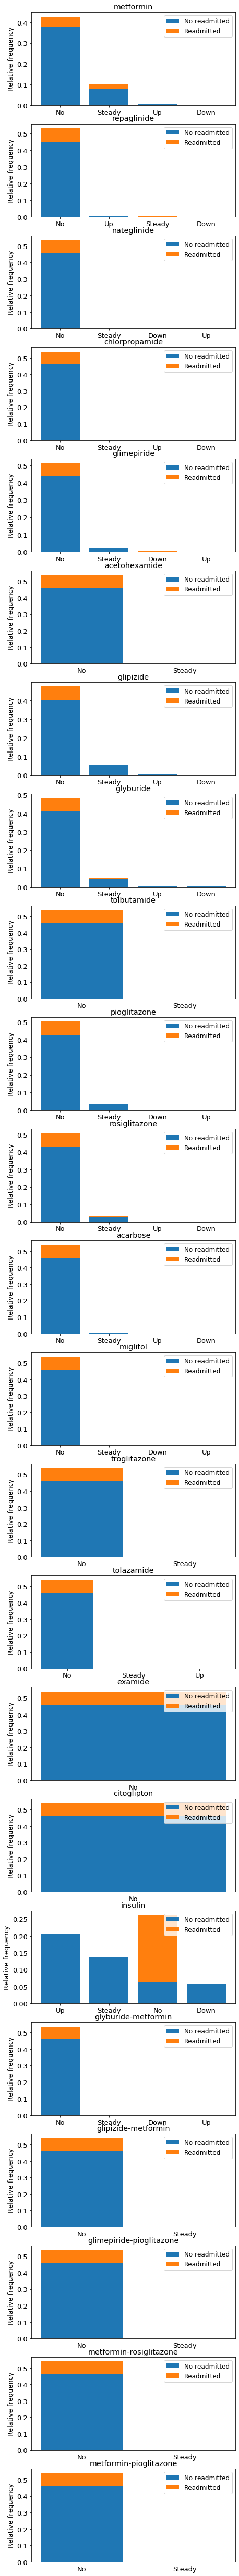

In [37]:
data_types = defaultdict(list)
for entry in hist_data_aux.schema.fields:
     data_types[str(entry.dataType)].append(entry.name)
categorical_variables = len(data_types["StringType"])
print("Number of categorical variables: {}\t Percentage: {:.2f}%". format(categorical_variables, \
                                                                      100*(categorical_variables/len(hist_data.columns))))
numerical_variables = len(data_types["IntegerType"])
print("Number of numerical variables: {}\t Percentage: {:.2f}%". format(numerical_variables, \
                                                                    100*(numerical_variables/len(hist_data.columns))))
fig, ax = plt.subplots(categorical_variables,1, figsize=(7,90))
plt.rcParams.update({'font.size': 12})

for i, categorical_variable in enumerate(data_types["StringType"]):
    aux=hist_data_aux.select(["readmitted", categorical_variable]).toPandas()
    aux_zero = aux[aux["readmitted"]==0][categorical_variable]
    ax[i].bar(aux_zero.unique(), aux_zero.value_counts()/hist_data_aux.count(), label="No readmitted", zorder=2)

    aux_one = aux[aux["readmitted"]==1][categorical_variable]
    ax[i].bar(aux_one.unique(), aux_one.value_counts()/hist_data_aux.count(), label="Readmitted", zorder=1)
    ax[i].set_title(categorical_variable)
    ax[i].legend()
    ax[i].set_ylabel("Relative frequency")

In [38]:
lr = LogisticRegression(maxIter=1000, regParam=0.001, elasticNetParam=0.8, featuresCol="features", labelCol="readmitted")
model = lr.fit(train_hist_trunc)

evaluator = BinaryClassificationEvaluator(labelCol='readmitted')

y_train_hist = model.transform(train_hist_trunc)
train_accuracy = evaluator.evaluate(y_train_hist)
print("Training accuracy: {:.2f}".format(train_accuracy))

y_val_hist = model.transform(val_hist_trunc)
val_accuracy = evaluator.evaluate(y_val_hist)
print("Validation accuracy: {:.2f}".format(val_accuracy))

y_test = model.transform(test_hist_trunc)
test_accuracy = evaluator.evaluate(y_test)
print("Test accuracy: {:.2f}".format(test_accuracy))

Training accuracy: 0.55
Validation accuracy: 0.55
Test accuracy: 0.55


Add column with the result

In [39]:
hist_data = hist_data.withColumn("Accuracy", lit(test_accuracy))

hist_data.printSchema()

root
 |-- encounter_id: string (nullable = true)
 |-- patient_nbr: string (nullable = true)
 |-- race: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: integer (nullable = true)
 |-- rep

### Prediction data


In [40]:
pred_data.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|             Class|       patient_nbr|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.348958333333

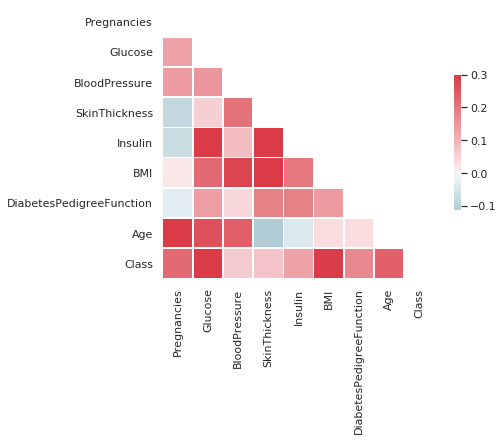

In [41]:
corr = pred_data.toPandas().corr(method='pearson', min_periods=1)
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

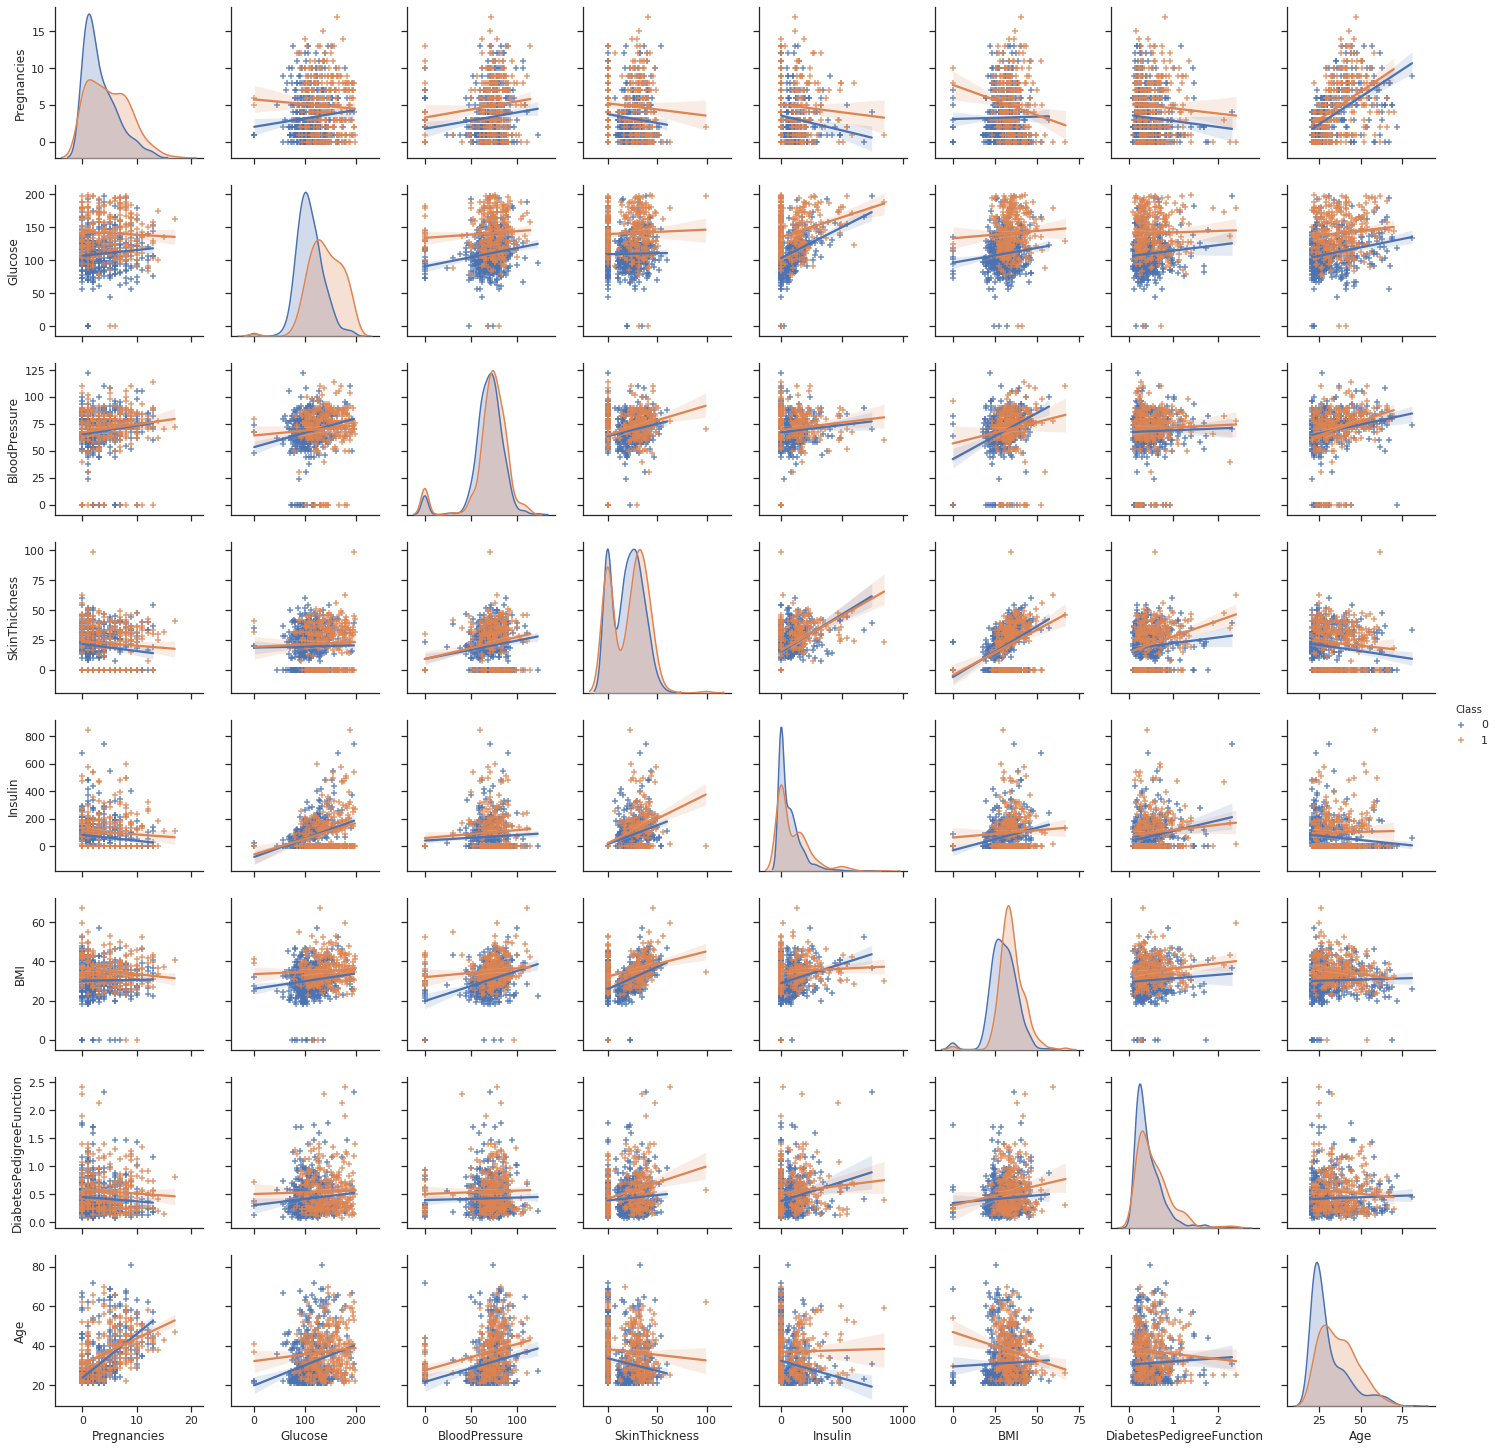

In [43]:
aux = pred_data.select("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Class").toPandas()
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(aux, hue="Class",markers="+", kind="reg")

In [44]:
model = LinearSVC(labelCol='Class')
paramGrid = ParamGridBuilder() \
        .addGrid(model.regParam, [1.0, 0.1, 0.01, 0.001, 0.0001, 0.0]) \
        .build()
evaluator = BinaryClassificationEvaluator(labelCol='Class')
crossval = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, parallelism=2, numFolds=5)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_pred_trunc)
print("Regularization parameter: {}".format(cvModel.bestModel._java_obj.getRegParam()))

y_train_pred = cvModel.transform(train_pred_trunc)
train_accuracy = evaluator.evaluate(y_train_pred)
print("Training accuracy: {:.2f}".format(train_accuracy))

y_val_pred = cvModel.transform(val_pred_trunc)
val_accuracy = evaluator.evaluate(y_val_pred)
print("Validation accuracy: {:.2f}".format(val_accuracy))

### Final model
model = LinearSVC(labelCol='Class', regParam=cvModel.bestModel._java_obj.getRegParam()).fit(train_predC_trunc)
y_test = model.transform(test_pred_trunc)
test_accuracy = evaluator.evaluate(y_test)
print("Test accuracy: {:.2f}".format(test_accuracy))

Regularization parameter: 0.1
Training accuracy: 0.85
Validation accuracy: 0.85
Test accuracy: 0.81


In [45]:
pred_data = pred_data.withColumn("Accuracy", lit(test_accuracy))
pred_data.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+-----------+-------------------+------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Class|patient_nbr|               date|          Accuracy|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+-----------+-------------------+------------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|    1|      50126|2020-07-09 00:00:00|0.8060803847475098|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|    0|      50127|2020-07-09 00:00:00|0.8060803847475098|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|    1|      50128|2020-07-09 00:00:00|0.8060803847475098|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|    0|      501

# Indexing data into elasticsearch

In [ ]:
myHost = "192.168.146.131"

es = Elasticsearch([{"host": myHost,"port":9200}]) # Connect to the elastic cluster
print(es)

def uploadToES(indexName, indexBody, docType=None, requestBody=None, verbose=True):
    if (es.indices.exists(indexName)==False): 
        es.indices.create(index=indexName, body=requestBody)
        if(verbose): print("creating {} index...".format(indexName))
    es.index(index=indexName,doc_type=docType, body=indexBody) # Store the document in Elasticsearch
    if(verbose): print("adding document {} to {} index...".format(indexBody, indexName))

In [ ]:
aux=hist_data.limit(200).toPandas()
for i in range(0, aux.shape[0]):
    body=aux.iloc[i].to_json(orient="index", date_format='iso')
    uploadToES("tfm-marta-historical-data", body)


aux=pred_data.toPandas()
for i in range(0, aux.shape[0]):
    body=aux.iloc[i].to_json(orient="index", date_format='iso')
    uploadToES("tfm-marta-prediction-data", body)
    
# an_requestBody = {
#     "mappings": {
#         "properties": {
#             "date": {"type": "date", "format":"yyyy-MM-dd HH:mm || yyyy-MM-dd || epoch_millis", "ignore_malformed":True},
#             "code": {"type": "keyword"},
#             "value":{"type": "long"}
#         }
#     }
# }

aux=an_data.toPandas()    
for j in range(0, aux.shape[0]):   
    body=aux.iloc[j].to_json(orient="index", date_format='iso')
    uploadToES("tfm-marta-analysis-data", body)